<a href="https://colab.research.google.com/github/g0dbot/COMP3610-GROUPM/blob/main/M1_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
! pip install -q kaggle
! pip install tensorflow
! pip install tensorflow-hub
! pip install numpy
! pip install pandas

# Pre Model Operations
The Dataset is 'AI-Artbench', which contains 185,000+ art pieces. The dataset has 3 groups; Human, Stable Diffusion Generated, and Latent Diffusion Generated. Each group has approximately 60,000 artworks at 256 x 256 resolution, except for the Standard Diffusion set which is at 768 x 768 resolution.

We use kaggle's api to pull directly from kaggle and then we upload the downloaded dataset to a mounted google drive.

In [2]:
from google.colab import files
import os
#you will need to upload your own kaggle json file
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## Downloading Dataset from Kaggle

In [3]:
dataset = 'ravidussilva/real-ai-art'
!kaggle datasets download -d $dataset

100% 9.95G/9.95G [02:34<00:00, 135MB/s]
100% 9.95G/9.95G [02:34<00:00, 69.3MB/s]


## Unzipping Dataset File

In [4]:
zip_file = "real-ai-art.zip"
destination_dir = f"/content"
if not os.path.exists(zip_file):
    print(f"Error: {zip_file} not found.")
else:
    !unzip -q $zip_file -d $destination_dir
    !rm $zip_file

## Mounting Google Drive (remove for submission)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p "/content/drive/My Drive/Project3610"

Mounted at /content/drive


## Uploading to Drive

In [ ]:
!zip -r /content/Real_AI_SD_LD_Dataset.zip /content/Real_AI_SD_LD_Dataset
!cp /content/Real_AI_SD_LD_Dataset.zip /content/drive/My Drive/Project3610

# Feature Extraction

## Data Preprocessing

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image_dataset_from_directory
import numpy as np
from keras.applications.vgg16 import preprocess_input
from pathlib import Path
import shutil
base = "/content/Real_AI_SD_LD_Dataset"
img_height = 256
img_width = 256

In [3]:
def copy_dir(src,dest):
  if Path(dest).exists():
    shutil.rmtree(dest)
  shutil.copytree(src,dest)


def filter_imageset(ai,art_style):
  ai_src = f"AI_{ai}_{art_style}"

  #temp directories /content/Real_AI_SD_LD_Dataset/train/AI_LD_art_nouveau

  train_path = '/content/Real_AI_SD_LD_Dataset/temp_train'
  test_path = '/content/Real_AI_SD_LD_Dataset/temp_test'

  train_ai = f"{train_path}/{ai_src}" #folder name in temp_train for AI images
  train_human = f"{train_path}/{art_style}" #folder name in temp_train for Human images

  test_ai = f"{test_path}/{ai_src}"#folder name in temp_test for Human images
  test_human = f"{test_path}/{art_style}"#folder name in temp_test for Human images

  train_dir = base+"/train" #/content/Real_AI_SD_LD_Dataset/train
  test_dir = base+"/test" #/content/Real_AI_SD_LD_Dataset/test


  tr_ai_dir, tr_human_dir = f"{train_dir}/{ai_src}", f"{train_dir}/{art_style}"
  test_ai_dir, test_human_dir = f"{test_dir}/{ai_src}", f"{test_dir}/{art_style}"

  #copying files into temporary directories
  copy_dir(tr_ai_dir,train_ai)
  copy_dir(tr_human_dir,train_human)

  copy_dir(test_ai_dir,test_ai)
  copy_dir(test_human_dir,test_human)

filter_imageset("LD","art_nouveau")

In [4]:
def get_image_data(ai,art_style):
  ai_src = f"AI_{ai}_{art_style}"

  train_path = '/content/Real_AI_SD_LD_Dataset/temp_train'
  test_path = '/content/Real_AI_SD_LD_Dataset/temp_test'

  classes = [ai_src, art_style]
  # classes = ['AI_LD_art_nouveau', 'art_nouveau']

  train = image_dataset_from_directory(
        train_path,
        validation_split=0.2,
        label_mode="binary",
        labels = 'inferred',
        class_names=classes,
        subset = "training",
        seed=64,
        image_size = (img_height, img_width),
        batch_size = 32,
  )
  validate = image_dataset_from_directory(
        train_path,
        validation_split=0.2,
        label_mode="binary",
        labels = 'inferred',
        class_names=classes,
        subset = "validation",
        seed=64,
        image_size = (img_height, img_width),
        batch_size = 32,
  )
  test = image_dataset_from_directory(
        test_path,
        label_mode="binary",
        labels="inferred",
        class_names=classes,
        seed=64,
        image_size = (img_height, img_width),
        batch_size = 32,
  )
  AUTOTUNE = tf.data.AUTOTUNE

  train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  validate = validate.cache().prefetch(buffer_size=AUTOTUNE)
  test = test.cache().prefetch(buffer_size=AUTOTUNE)


  return train,validate,test


train_ds,val_ds,test_ds = get_image_data("LD","art_nouveau")




Found 9992 files belonging to 2 classes.
Using 7994 files for training.
Found 9992 files belonging to 2 classes.
Using 1998 files for validation.
Found 2000 files belonging to 2 classes.


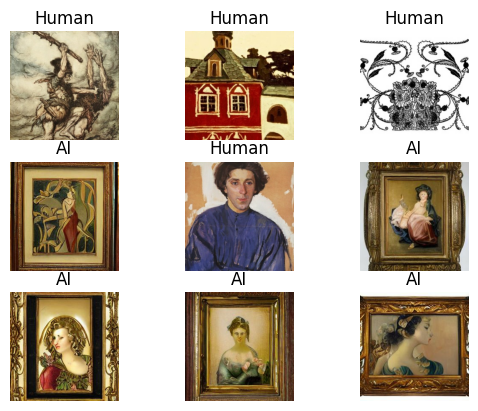

In [5]:
import matplotlib.pyplot as plt
images = []
labels = []
for i, l in train_ds:
  images = i
  labels = l
  break
cn = ['AI', 'Human']
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(cn[labels[i].numpy().astype("uint8")[0]])
  plt.axis("off")



In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 3)
(32, 1)


## Feature Extraction Using VGG16

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Rescaling
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
import pandas as pd


# Pre-Trained Layers unfrozen as the task of classifying whether an image is AI or Human Generated is significantly different to classification based on image elements
# "Is it AI Generated?" != "What is in the Image"
# Top of pretrained VGG16 kept to maintain neural network's basic knowledge of image element identification
model = VGG16(weights='imagenet', include_top=False,input_shape=(img_height, img_width, 3))

def extract_features(dataset,csv_filename):
    size = len(dataset)*0.1
    features_list = []
    labels_list = []
    for images, labels in dataset:
      if(size<0):
        break
      preprocessed_images = preprocess_input(images)
      features_list.append(preprocessed_images)
      labels_list.append(labels.numpy())
      size-=1
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list,axis=0)
    features_pred = model.predict(features)

    features_flattened = features_pred.reshape(features_pred.shape[0], -1)

    features_df = pd.DataFrame(features_flattened)
    features_df['label'] = labels

    features_df.to_csv(csv_filename, mode='a', index=False)

    return features_pred





# present = 3
filebase = "art_nouveau_LD_vs_Human_"
# train_features = extract_features(train_ds,present,f"{filebase}train.csv")
train_features = extract_features(train_ds,f"{filebase}train.csv")

# validate_features = extract_features(val_ds,present,f"{filebase}val.csv")
validate_features = extract_features(val_ds,f"{filebase}val.csv")

# test_features = extract_features(test_ds,present,f"{filebase}test.csv")
test_features = extract_features(test_ds,f"{filebase}test.csv")

7/7 [==============================] - 183s 26s/step


## Feature Reloading from CSVs

In [9]:
train_csv = "/content/art_nouveau_LD_vs_Human_test.csv"
train_data =  pd.read_csv("/content/art_nouveau_LD_vs_Human_test.csv")
train_data.head()
x_train = train_data.copy()
y_train = x_train.pop('label')



,0,1,2,3,4,5,6,7,8,9,...,32758,32759,32760,32761,32762,32763,32764,32765,32766,32767
0,0.80229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,28.008533,0.0,0.000000,0.0
2,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,6.353663,0.0
3,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
4,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.826865,0.0,0.000000,0.0


# Classifier Models

## VGG16

In [7]:

model_vgg = Sequential([
    model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_vgg.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy'),
        keras.metrics.FalseNegatives(),
    ]
)
epochs=10
model_vgg.summary()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 23169601 (88.39 MB)
Trainable params: 23169601 (88.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
epochs=10
ai_detect_vgg16 = model_vgg.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/10
 17/250 [=>............................] - ETA: 5:49:01 - loss: 30.7865 - accuracy: 0.5037 - false_negatives: 175.0000

KeyboardInterrupt: 

## ResNet 50

In [ ]:
from keras.applications.resnet50 import ResNet50

## CNN